In [1]:
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
import os
import datetime

#Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# sklearn stuff
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, mean_squared_error, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, Imputer 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

import feature_pipelines as pipes

In [2]:
maindir = "/home/anerdi/Desktop/Zillow"

logerror = pd.read_csv(maindir + "/data/train_2016_v2.csv/train_2016_v2.csv")
logerror['weeknumber'] = logerror['transactiondate'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').isocalendar()[1])
logerror['month'] = logerror['transactiondate'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').month)
properties = pd.read_csv(maindir + "/data/properties_2016.csv/properties_2016.csv")

/home/anerdi/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#proportion of living area
properties['N-LivingAreaProp'] = properties['calculatedfinishedsquarefeet']/properties['lotsizesquarefeet']

#Ratio of the built structure value to land area
properties['N-ValueProp'] = properties['structuretaxvaluedollarcnt']/properties['landtaxvaluedollarcnt']

#Ratio of tax of property over parcel
properties['N-ValueRatio'] = properties['taxvaluedollarcnt']/properties['taxamount']

# Pool
properties['Pool'] = (properties['pooltypeid2'].fillna(0) + properties['pooltypeid7'].fillna(0)).astype(int)

In [4]:
# join on parcel id
data = pd.merge(properties,logerror[['parcelid','logerror','month']], on='parcelid')
del logerror

### New response variable - Overestimation

In [5]:
data['overestimation'] = (data['logerror'] >= 0).astype(int)

### Feature selection and Feature Processing

In [44]:
# Setup variables considered in the model


# numerical variables
num_atts = ['bathroomcnt','bedroomcnt','buildingqualitytypeid','calculatedbathnbr','finishedfloor1squarefeet',
           'calculatedfinishedsquarefeet','finishedsquarefeet12','finishedsquarefeet13',
           'finishedsquarefeet15','finishedsquarefeet50','finishedsquarefeet6','fireplacecnt',
           'fullbathcnt','garagecarcnt','garagetotalsqft','latitude','longitude','lotsizesquarefeet',
           'poolcnt','poolsizesum','censustractandblock','roomcnt','threequarterbathnbr','unitcnt',
           'yardbuildingsqft17','yardbuildingsqft26','numberofstories',
            'structuretaxvaluedollarcnt','taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount',
           'N-ValueRatio', 'N-LivingAreaProp', 'N-ValueProp']

# categorical varaibles
cat_atts = ['airconditioningtypeid','architecturalstyletypeid',
           'buildingclasstypeid','heatingorsystemtypeid','pooltypeid10','pooltypeid2',
            'pooltypeid7','propertylandusetypeid','regionidcounty',
           'storytypeid','typeconstructiontypeid','yearbuilt','fireplaceflag',
           'taxdelinquencyflag']

# Dictionary of categorical variables and their default levels
cat_dict = {key:value for key,value in {'airconditioningtypeid':[-1] + list(range(1,14)),
           'architecturalstyletypeid':[-1] + list(range(1,28)),
           'buildingclasstypeid':[-1] + list(range(1,6)),
            'heatingorsystemtypeid':[-1] + list(range(1,26)),
            'pooltypeid10': list(range(-1,2)),
            'pooltypeid2': list(range(-1,2)),
            'pooltypeid7': list(range(-1,2)),
            'Pool': [0,1],
            'propertylandusetypeid': [-1, 31,46,47,246,247,248,260,261,262,263,264,265,266,267,268,269,270,271,
                                     273,274,275,276,279,290,291],
            'regionidcounty': [2061,3101,1286],
            'storytypeid':[-1] + list(range(1,36)),
            'typeconstructiontypeid':[-1] + list(range(1,19)),
            'yearbuilt': [-1] + list(range(1885,2018)),
            'fireplaceflag': [-1] + ['True','False'],
            'taxdelinquencyflag': [-1] + ['Y','N']
           }.items() if key in cat_atts}

In [45]:
# Categorical pipeline
cat_pipeline = Pipeline([
        ('select_and_dummify', pipes.DF_Selector_GetDummies(cat_dict)),
    ])

# Numerical pipeline
num_pipeline = Pipeline([
        ('selector', pipes.DataFrameSelector(num_atts)),
        ('imputer', Imputer()),
        ('scaler', StandardScaler())
    ])

# Full pipeline
feature_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline)
    ])

## Training Classifiers

In [46]:
X=feature_pipeline.fit_transform(data)
y=data.overestimation

#### Logistic regression

In [47]:
from sklearn.linear_model import LogisticRegression

In [48]:
clf_l1_LR = LogisticRegression(penalty='l1', tol=0.01)
clf_l1_LR.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.01,
          verbose=0, warm_start=False)

In [49]:
clf_l1_LR.score(X,y)

0.57445582941013573

In [50]:
clf_l1_LR.predict_proba(X).mean(axis=0)

array([ 0.43942342,  0.56057658])

In [51]:
confusion_matrix(data['overestimation'], clf_l1_LR.predict(X), labels=[0,1])

array([[ 7852, 31815],
       [ 6601, 44007]])

### Plotting 

In [79]:
def plot_conf_matrix(model):
    false_postives = np.where((model.predict_proba(X)[:,1] >= 0.50) & (data['logerror'] < 0))[0]
    true_postives = np.where((model.predict_proba(X)[:,1] >= 0.50) & (data['logerror'] >= 0))[0]
    true_negatives = np.where((model.predict_proba(X)[:,1] < 0.50) & (data['logerror'] < 0))[0]
    false_negatives = np.where((model.predict_proba(X)[:,1] < 0.50) & (data['logerror'] >= 0))[0]
    
    plt.figure(figsize=(10,10))
    plt.scatter(model.predict_proba(X)[false_postives,1], data.iloc[false_postives,:]['logerror'],color='red', alpha=0.5)
    plt.scatter(model.predict_proba(X)[true_postives,1], data.iloc[true_postives,:]['logerror'],color='blue', alpha=0.5)
    plt.scatter(model.predict_proba(X)[false_negatives,1], data.iloc[false_negatives,:]['logerror'],color='red', alpha=0.5)
    plt.scatter(model.predict_proba(X)[true_negatives,1], data.iloc[true_negatives,:]['logerror'],color='blue',alpha=0.5)
    plt.show()

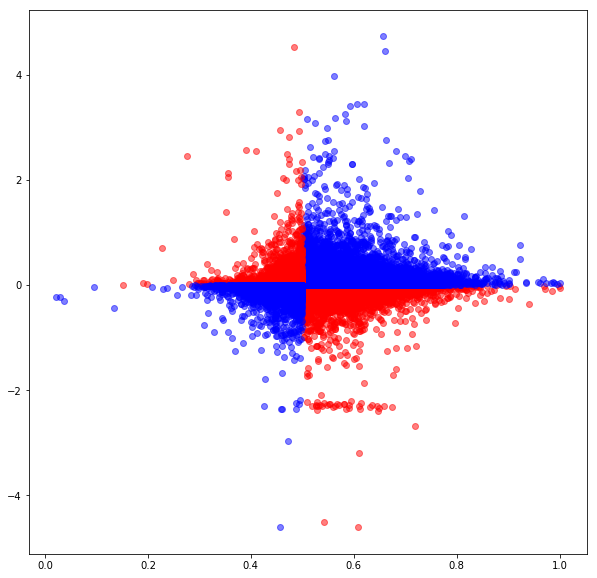

In [80]:
plot_conf_matrix(clf_l1_LR)

#### Random Forests 

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [75]:
clf_rf = RandomForestClassifier(max_depth=20, random_state=9)

In [76]:
clf_rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=9, verbose=0, warm_start=False)

In [77]:
clf_rf.score(X,y)

0.74092495153697036

In [78]:
confusion_matrix(data['overestimation'], clf_rf.predict(X), labels=[0,1])

array([[20493, 19174],
       [ 4214, 46394]])

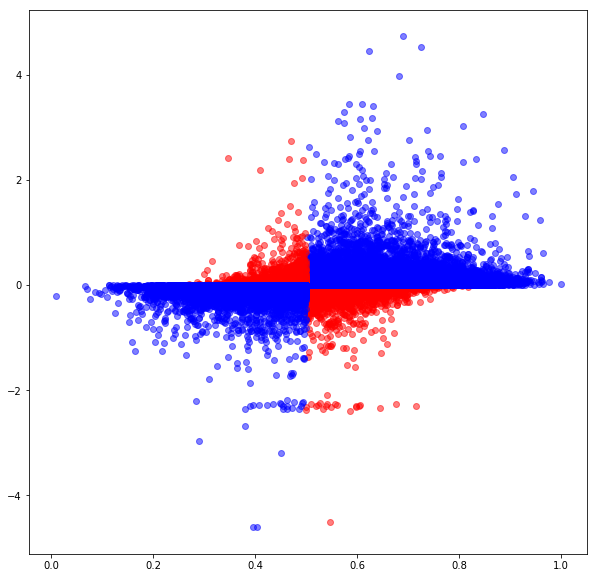

In [81]:
plot_conf_matrix(clf_rf)

### Predict on properties data frame

In [61]:
probabilities = None
for i in range(int(properties.shape[0] / 100000)):   
    # get current test features
    current_test_feats = feature_pipeline.transform(properties.iloc[i*100000:(i+1)*100000])
    
    # predict on current test obs
    current_probs = Series(clf_l1_LR.predict_proba(current_test_feats)[:,1], name='overestimate_prob',
                          index = np.arange(i*100000,(i+1)*100000))
    
    if probabilities is not None:
        probabilities = pd.concat([probabilities, current_probs])
    else:
        probabilities = current_probs

#  fencepost problem
current_test_feats = feature_pipeline.transform(properties.iloc[2900000:])
current_probs = Series(clf_l1_LR.predict_proba(current_test_feats)[:,1], name='overestimate_prob',
                      index = np.arange(2900000,2985217))
probabilities = pd.concat([probabilities, current_probs])

In [64]:
del properties
import gc
gc.collect()

7

In [65]:
overestimate_probs = pd.read_csv(maindir + "/data/properties_2016.csv/properties_2016.csv", usecols=['parcelid'])
overestimate_probs = pd.concat([overestimate_probs, probabilities], axis=1)
overestimate_probs.head()

In [69]:
overestimate_probs.shape

(2985217, 2)

In [73]:
overestimate_probs.to_csv("/home/anerdi/Desktop/Zillow/twostagemodel/overestimate_probs.csv", index=False)